In [8]:
import numpy as np
from tqdm import tqdm as tqdm
import pandas as pd
import subprocess
from glob import glob

In [4]:
genotype_path = '/cluster/raid/home/f80878961/beestrong/data/queen_genotypes/'
queen_path  = '{}queen/'.format(genotype_path)
suisse_path = '{}suisse/'.format(genotype_path)
phased_path = '{}phased/'.format(suisse_path)
suisse_shared_snps_path  = '{}suisse_shared_snps/'.format(suisse_path)
old_phased_path =  '{}old_phased/'.format(suisse_path)

In [30]:
id_mapper = {
'BS18-102':'BS18-0102',
'BS18-103':'BS18-0103',
'BS16-276':'BS16-0276',
'BS16-277':'BS16-0277',
'BS16-279':'BS16-0279',
'BS18-270':'BS18-0270',
'BS18-312':'BS18-0312',
'BS18-313':'BS18-0313',
'BS18-314':'BS18-0314',
'BS18-315':'BS18-0315',
'BS18-316':'BS18-0316',
'BS18-318':'BS18-0318',
'BS18-319':'BS18-0319',
'BS18-321':'BS18-0321',
'BS18-322':'BS18-0322',
'BS18-323':'BS18-0323',
'BS18-324':'BS18-0324',
'BS18-325':'BS18-0325',
'BS18-326':'BS18-0326',
'BS18-328':'BS18-0328',
'BS18-329':'BS18-0329',
'BS16-275':'BS16-0275',
'BS18-311':'BS18-0311',
'BS18-317':'BS18-0317',
'BS18-320':'BS18-0320',
'BS18-327':'BS18-0327',
'Suisse1': 'Suisse01',
'Suisse2': 'Suisse02',
'Suisse3': 'Suisse03',
'Suisse4': 'Suisse04',
'Suisse5': 'Suisse05',
'Suisse6': 'Suisse06',
'Suisse7': 'Suisse07',
'Suisse8': 'Suisse08',
'Suisse9': 'Suisse09'
}

### harmonized colony ids

In [46]:
phased_tfam = pd.read_csv('{}queen_phased.tfam'.format(phased_path), sep='\s', header=None)
suisse_tfam = pd.read_csv('{}suisse.tfam'.format(suisse_path), sep='\s', header=None)

/tmp/ipykernel_550146/1205618444.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  phased_tfam = pd.read_csv('{}queen_phased.tfam'.format(phased_path), sep='\s', header=None)
/tmp/ipykernel_550146/1205618444.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  suisse_tfam = pd.read_csv('{}suisse.tfam'.format(suisse_path), sep='\s', header=None)


In [48]:
phased_tfam[1] = phased_tfam[1].map(lambda x: x.split('_')[0])
phased_tfam[1] = phased_tfam[1].replace(id_mapper)
phased_tfam[1] = phased_tfam[1].map(lambda x: x.replace('-', '_'))

In [49]:
suisse_tfam[1] = suisse_tfam[1].replace(id_mapper)
suisse_tfam[0] = [0] * len(suisse_tfam)
suisse_tfam[1] = suisse_tfam[1].map(lambda x: x.replace('-', '_'))

In [50]:
assert len(set(phased_tfam[1]).difference(suisse_tfam[1])) == 0
assert len(set(suisse_tfam[1]).difference(phased_tfam[1])) == 0

In [56]:
phased_tfam.to_csv('{}phased_harm.tfam'.format(phased_path), sep='\t', header=None, index=False)
suisse_tfam.to_csv('{}suisse_harm.tfam'.format(suisse_path), sep='\t', header=None, index=False)

create plink files

plink --tped suisse_harm.tped --tfam suisse_harm.tfam --make-bed --out suisse

plink --tped phased_harm.tped --tfam phased_harm.tfam --make-bed --out phased

check genetic concordance

plink --bfile suisse --bmerge ../phased/phased.bed ../phased/phased.bim ../phased/phased.fam --merge-mode 6 --out suisse_phased_concordance

### where are the missing calls?

In [59]:
phased_bim = pd.read_csv('{}phased.bim'.format(phased_path), sep='\t', header=None)

In [61]:
common_snps = set(phased_bim[1])

In [81]:
suisse_tped_file = '{}suisse_harm.tped'.format(suisse_path)
phased_tped_file = '{}phased_harm.tped'.format(phased_path)
shared_tped_file = '{}suisse_shared.tped'.format(suisse_shared_snps_path)

In [78]:
suisse_missing_call_nr = 0
with open(suisse_tped_file, 'r') as inf:
    for l in tqdm(inf):
        split_line = l.split()
        if split_line[1] in common_snps:
            suisse_missing_call_nr += split_line[4:].count('0')

phased_missing_call_nr = 0
with open(phased_tped_file, 'r') as inf:
    for l in tqdm(inf):
        split_line = l.split()
        if split_line[1] in common_snps:
            phased_missing_call_nr += split_line[4:].count('0')

6914967it [01:26, 79666.61it/s]
5944683it [01:22, 71886.56it/s]


In [79]:
print('suisse', suisse_missing_call_nr)
print('phased', phased_missing_call_nr)

suisse 312983538
phased 0


In [115]:
# h every filtered SNP has >0 missing calls
nr_snp_with_missing_calls = 0
with open(suisse_tped_file, 'r') as inf:
    for l in tqdm(inf):
        split_line = l.split()
        # if split_line[1] not in common_snps:
        if split_line[4:].count('0') > 0: 
            nr_snp_with_missing_calls += 1

6914967it [01:30, 76755.34it/s]


In [116]:
nr_snp_with_missing_calls

3372429

In [82]:
snp_nr = 0
with open(shared_tped_file, 'w') as outf:
    with open(suisse_tped_file, 'r') as inf:
        for l in tqdm(inf):
            if l.split()[1] in common_snps:
                snp_nr += 1
                outf.write(l)

6914967it [00:52, 132750.19it/s]


In [83]:
assert snp_nr == 5944683

### subset my genotypes

In [8]:
queen_suisse_path = '{}queen_suisse/'.format(suisse_path)

In [6]:
phased_fam = pd.read_csv('{}phased.fam'.format(phased_path), sep='\s', header=None)

/tmp/ipykernel_3289792/301746287.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  phased_fam = pd.read_csv('{}phased.fam'.format(phased_path), sep='\s', header=None)


In [19]:
queen_suisse_fam = phased_fam[phased_fam[1].str.startswith('BS')]
queen_suisse_fam[0] = queen_suisse_fam[1]

/tmp/ipykernel_3289792/3886684702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  queen_suisse_fam[0] = queen_suisse_fam[1]


In [28]:
queen_suisse_fam.loc[:, :1].to_csv('{}suisse_colonies.txt'.format(queen_path), sep='\t', header=None, index=False)

### SNP sets comparison

In [38]:
suisse_bim = pd.read_csv('{}suisse/suisse.bim'.format(suisse_path), sep='\t', header=None)

In [39]:
queen_bim = pd.read_csv('{}queen.bim'.format(queen_path), sep='\t', header=None)

In [42]:
print(len(set(suisse_bim[1]).intersection(queen_bim[1])))
print(len(set(suisse_bim[1]).difference(queen_bim[1])))
print(len(set(queen_bim[1]).difference(suisse_bim[1])))

6676373
238594
87999


In [40]:
suisse_bim

,0,1,2,3,4,5
0,1,1:5671,0,5671,0,T
1,1,1:5698,0,5698,C,T
2,1,1:6621,0,6621,0,A
3,1,1:6717,0,6717,0,C
4,1,1:6823,0,6823,0,G
...,...,...,...,...,...,...
6914962,17,17:15973,0,15973,0,A
6914963,17,17:15978,0,15978,0,A
6914964,17,17:15982,0,15982,T,C
6914965,17,17:16001,0,16001,A,T


In [45]:
# how many SNP except in first 16 chromosome?
len(suisse_bim[suisse_bim[0] == 17])

276

In [25]:
# compare ref and alternative alleles

In [30]:
suisse_bim_df[[1, 4, 5]].column = [, 

/tmp/ipykernel_2634109/41790922.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  suisse_bim_df[[1, 4, 5]].column = ['SNP_ID', 'ALT_suisse', 'REF_suisse']


In [46]:
suisse_bim = suisse_bim.rename(columns={1: 'SNP_ID', 4: 'ALT_suisse', 5 : 'REF_suisse'})
queen_bim = queen_bim.rename(columns={1: 'SNP_ID', 4: 'ALT_queen', 5 : 'REF_queen'})

In [47]:
mdf = suisse_bim[['SNP_ID', 'ALT_suisse', 'REF_suisse']].merge(queen_bim[['SNP_ID', 'ALT_queen', 'REF_queen']], on='SNP_ID')

In [48]:
mdf

,SNP_ID,ALT_suisse,REF_suisse,ALT_queen,REF_queen
0,1:5671,0,T,0,T
1,1:5698,C,T,C,T
2,1:6621,0,A,G,A
3,1:6717,0,C,0,C
4,1:6823,0,G,C,G
...,...,...,...,...,...
6676368,16:7225908,0,T,C,T
6676369,16:7225911,T,C,T,C
6676370,16:7226186,0,G,A,G
6676371,16:7226346,0,G,0,G


In [67]:
mdf['ALT_queen'].to_list().count('0')

1164510

In [72]:
np.sum((mdf['ALT_suisse'] ==  mdf['ALT_queen']) & (mdf['ALT_queen'] == '0'))

1127660

In [73]:
1127660 / 1164510

0.968355789130192

In [74]:
mdf_nonmissing = mdf[(mdf['ALT_suisse'] != '0') & (mdf['ALT_queen'] != '0')]

2920601

In [78]:
np.sum(mdf_nonmissing['ALT_suisse'] ==  mdf_nonmissing['ALT_queen'])    / len(mdf_nonmissing)

0.8424766022871994

In [64]:
np.sum(mdf['REF_suisse'] == mdf['REF_queen']) / len(mdf)

0.918548439399656

In [70]:
mdf[mdf['ALT_queen'] == '0']

,SNP_ID,ALT_suisse,REF_suisse,ALT_queen,REF_queen
0,1:5671,0,T,0,T
3,1:6717,0,C,0,C
12,1:7366,0,A,0,A
13,1:7507,0,C,0,C
25,1:8215,0,T,0,T
...,...,...,...,...,...
6676354,16:7225323,0,T,0,T
6676357,16:7225595,0,G,0,G
6676363,16:7225697,0,A,0,A
6676371,16:7226346,0,G,0,G


In [50]:
set(mdf['REF_suisse'] == mdf['REF_queen'])

{False, True}

In [46]:
set(mdf['ALT_suisse'] == mdf['ALT_phased'])

{True}

In [47]:
mdf


,SNP_ID,ALT_suisse,REF_suisse,ALT_phased,REF_phased
0,1:5671,.,T,.,T
1,1:5698,C,T,C,T
2,1:6621,.,A,.,A
3,1:6823,.,G,.,G
4,1:6832,.,G,.,G
...,...,...,...,...,...
5944678,16:7225891,A,G,A,G
5944679,16:7225908,.,T,.,T
5944680,16:7225911,T,C,T,C
5944681,16:7226346,.,G,.,G


### impact on H2

GRM computation

gcta64 --bfile suisse --make-grm --maf 0.01 --out suisse

In [29]:
pheno_df = pd.read_csv('/cluster/raid/home/f80878961/beestrong/tlf/BeeStrong_metadata.csv')

In [30]:
plink_path = queen_suisse_path
prefix = 'queen_suisse'

In [32]:
fam_df = pd.read_csv('{}{}.fam'.format(plink_path, prefix), sep='\s', header=None)

/tmp/ipykernel_3289792/985640762.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  fam_df = pd.read_csv('{}{}.fam'.format(plink_path, prefix), sep='\s', header=None)


In [33]:
fam_df

,0,1,2,3,4,5
0,BS16_0275,BS16_0275,0,0,0,-9
1,BS16_0276,BS16_0276,0,0,0,-9
2,BS16_0277,BS16_0277,0,0,0,-9
3,BS16_0279,BS16_0279,0,0,0,-9
4,BS16_0280,BS16_0280,0,0,0,-9
...,...,...,...,...,...,...
205,BS18_0325,BS18_0325,0,0,0,-9
206,BS18_0326,BS18_0326,0,0,0,-9
207,BS18_0327,BS18_0327,0,0,0,-9
208,BS18_0328,BS18_0328,0,0,0,-9


In [34]:
columns = ['Colony', 'log_v_pho', 'log_v_meta', 'Apiary', 'date', 'Year', 'Day of Year']
bs_ids = pheno_df['Colony'][pheno_df['Colony'].isin(phased_fam[1])].to_list()
gcta_pheno_df = pd.DataFrame(
    {
        '0' : [0] * len(bs_ids),
        'Colony': bs_ids
    }
)
gcta_pheno_df = gcta_pheno_df.merge(pheno_df[columns], on='Colony', how='left')
gcta_pheno_df = gcta_pheno_df.fillna('NA')

In [35]:
len(bs_ids)

210

In [36]:
# phenotypes (for queen_suisse fam id = ind id... not 0)
fn = '{}{}.v_pho'.format(plink_path, prefix)
gcta_pheno_df[['Colony', 'Colony', 'log_v_pho']].to_csv(fn, header=None, sep='\t', index=False)

fn = '{}{}.v_meta'.format(plink_path, prefix)
gcta_pheno_df[['Colony', 'Colony', 'log_v_meta']].to_csv(fn, header=None, sep='\t', index=False)

# cat covars
fn = '{}{}.covar'.format(plink_path, prefix)
gcta_pheno_df[['Colony', 'Colony', 'Apiary']].to_csv(fn, header=None, sep='\t', index=False)

# cont covar
fn = '{}{}.qcovar'.format(plink_path, prefix)
gcta_pheno_df[['Colony', 'Colony', 'Day of Year']].to_csv(fn, header=None, sep='\t', index=False)


In [111]:
# phenotypes
fn = '{}{}.v_pho'.format(plink_path, prefix)
gcta_pheno_df[['0', 'Colony', 'log_v_pho']].to_csv(fn, header=None, sep='\t', index=False)

fn = '{}phased.v_pho'.format(phased_path)
gcta_pheno_df[['0', 'Colony', 'log_v_pho']].to_csv(fn, header=None, sep='\t', index=False)

fn = '{}suisse.v_meta'.format(suisse_path)
gcta_pheno_df[['0', 'Colony', 'log_v_meta']].to_csv(fn, header=None, sep='\t', index=False)

fn = '{}phased.v_meta'.format(phased_path)
gcta_pheno_df[['0', 'Colony', 'log_v_meta']].to_csv(fn, header=None, sep='\t', index=False)

# cat covars
fn = '{}suisse.covar'.format(suisse_path)
gcta_pheno_df[['0', 'Colony', 'Apiary']].to_csv(fn, header=None, sep='\t', index=False)

fn = '{}phased.covar'.format(phased_path)
gcta_pheno_df[['0', 'Colony', 'Apiary']].to_csv(fn, header=None, sep='\t', index=False)

# cont covar
fn = '{}suisse.qcovar'.format(suisse_path)
gcta_pheno_df[['0', 'Colony', 'Day of Year']].to_csv(fn, header=None, sep='\t', index=False)

fn = '{}phased.qcovar'.format(phased_path)
gcta_pheno_df[['0', 'Colony', 'Day of Year']].to_csv(fn, header=None, sep='\t', index=False)

gcta64 --reml --grm suisse --pheno suisse.v_pho --mpheno 1 –-covar suisse.covar –-qcovar suisse.qcovar --out suisse_v_pho

markus queen_phased dataset vs. suisse dataset

1. 5944683 snp in queen_phased, all included in the 6914967 SNP from suisse  (incl. 276 on chromosome 17)

In [3]:
phased_bim_df = pd.read_csv('{}suisse_queen_phased/queen_phased.bim'.format(plink_path), sep='\t', header=None)
suisse_bim_df = pd.read_csv('{}suisse_queen_phased/suisse.bim'.format(plink_path), sep='\t', header=None)
# queen_bim_df = pd.read_csv('{}queen.bim'.format(plink_path), sep='\t', header=None)

In [4]:
print(len(set(phased_bim_df[1]).intersection(suisse_bim_df[1])))
print(len(set(phased_bim_df[1]).difference(suisse_bim_df[1])))
print(len(set(suisse_bim_df[1]).difference(phased_bim_df[1])))

5944683
0
970284


other comparisons

In [20]:
print(len(set(queen_bim_df[1]).intersection(suisse_bim_df[1])))
print(len(set(queen_bim_df[1]).difference(suisse_bim_df[1])))
print(len(set(suisse_bim_df[1]).difference(queen_bim_df[1])))

6676373
87999
238594


In [22]:
print(len(set(phased_bim_df[1]).intersection(queen_bim_df[1])))
print(len(set(phased_bim_df[1]).difference(queen_bim_df[1])))
print(len(set(queen_bim_df[1]).difference(phased_bim_df[1])))

5843454
101229
920918


In [4]:
phased_bim_df

,0,1,2,3,4,5
0,1,1:5671,0,5671,.,T
1,1,1:5698,0,5698,C,T
2,1,1:6621,0,6621,.,A
3,1,1:6823,0,6823,.,G
4,1,1:6832,0,6832,.,G
...,...,...,...,...,...,...
5944678,16,16:7225891,0,7225891,A,G
5944679,16,16:7225908,0,7225908,.,T
5944680,16,16:7225911,0,7225911,T,C
5944681,16,16:7226346,0,7226346,.,G


In [9]:
suisse_bim_df

,0,1,2,3,4,5
0,1,1:5671,0,5671,0,T
1,1,1:5698,0,5698,C,T
2,1,1:6621,0,6621,0,A
3,1,1:6717,0,6717,0,C
4,1,1:6823,0,6823,0,G
...,...,...,...,...,...,...
6914962,17,17:15973,0,15973,0,A
6914963,17,17:15978,0,15978,0,A
6914964,17,17:15982,0,15982,T,C
6914965,17,17:16001,0,16001,A,T


276

6914691

In [8]:
suisse_bim_df[suisse_bim_df[0] != 17].reset_index()

,index,0,1,2,3,4,5
0,0,1,1:5671,0,5671,0,T
1,1,1,1:5698,0,5698,C,T
2,2,1,1:6621,0,6621,0,A
3,3,1,1:6717,0,6717,0,C
4,4,1,1:6823,0,6823,0,G
...,...,...,...,...,...,...,...
6914686,6914686,16,16:7225911,0,7225911,T,C
6914687,6914687,16,16:7226186,0,7226186,0,G
6914688,6914688,16,16:7226346,0,7226346,0,G
6914689,6914689,16,16:7227034,0,7227034,0,G


## compare admixture


In [6]:
pheno_df = pd.read_csv('/cluster/raid/home/f80878961/beestrong/tlf/BeeStrong_metadata.csv')

In [5]:
adm_path = '/cluster/raid/home/f80878961/beestrong/data/queen_genotypes/suisse/suisse_pop/genetic_composition/'

In [7]:
pheno_df

,Colony,date,Genetic group,percent_Ligustica_Carnica,percent_Mellifera,percent_Caucasica,bee_weigth,nbr_pho_varroa,nbr_pho_varroa_100bee,v_pho,...,Day of Year,Latitude,Longitude,v_meta,log_v_meta,log_v_pho,log_v_mito,Varroa group,Recapping group,DMR group
0,BS16_0001,01/08/2016,hybrid,0.158920,0.712885,0.128195,38.5,55.0,19.0,20.000000,...,214,44.0,5.167,0.000438,-7.733771,2.995732,-1.175053,High,High,Low
1,BS16_0002,01/08/2016,hybrid,0.001545,0.776361,0.222094,36.1,10.0,4.0,3.878116,...,214,44.0,5.167,0.000031,-10.366754,1.355350,-4.171704,Medium,Medium,Low
2,BS16_0003,01/08/2016,hybrid,0.752977,0.206098,0.040926,39.0,12.0,4.0,4.307692,...,214,44.0,5.167,0.000028,-10.470614,1.460402,-4.166909,Medium,Medium,Medium
3,BS16_0004,29/09/2016,Mellifera,0.066520,0.829661,0.103819,40.7,12.0,4.0,4.127764,...,273,44.0,5.167,0.000059,-9.730852,1.417736,-3.265586,Medium,High,High
4,BS16_0005,28/07/2016,hybrid,0.578850,0.409558,0.011593,45.0,14.0,4.0,4.355556,...,210,44.0,5.167,0.000078,-9.457242,1.471452,-2.902179,High,Low,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1437,BS18_0675,18/10/2018,Ligustica_Carnica,0.999239,0.000041,0.000720,45.0,8.0,2.0,2.488889,...,291,44.0,5.167,0.000081,-9.424306,0.911836,NaN,High,Medium,Medium
1438,BS18_0681,17/10/2018,hybrid,0.582663,0.000738,0.416599,47.0,74.0,21.0,22.042553,...,290,43.5,5.167,0.000411,-7.796449,3.092975,-1.063650,High,High,High
1439,BS18_0682,17/10/2018,hybrid,0.414228,0.395046,0.190726,47.0,35.0,10.0,10.425532,...,290,43.5,5.167,0.000154,-8.775812,2.344258,-2.046166,High,High,Low
1440,BS18_0684,17/10/2018,Ligustica_Carnica,0.988999,0.000257,0.010744,64.0,29.0,6.0,6.343750,...,290,43.5,5.167,0.000118,-9.041880,1.847470,-2.482229,High,High,Medium


In [61]:
bs_ids = []
percent_Mellifera_CH = []
percent_Caucasica_CH = []
percent_Ligustica_Carnica_CH = []
genetic_group_CH = []

for f in glob('{}*.Q'.format(adm_path)):
    bs_ids.append(f.split('sim_depth_count')[-1].split('_')[0])
    with open(f, 'r') as inf:
        pm = float(inf.readline().split(',')[1])
        pc = float(inf.readline().split(',')[1])
        plc = float(inf.readline().split(',')[1])
        percent_Mellifera_CH.append(pm)
        percent_Caucasica_CH.append(pc)
        percent_Ligustica_Carnica_CH.append(plc)
        
        if pm >= 0.8:
            genetic_group_CH.append('Mellifera')
        elif pc >= 0.8:
            genetic_group_CH.append('Caucasica')
        elif plc >= 0.8:
            genetic_group_CH.append('Ligustica_Carnica') 
        else:
            genetic_group_CH.append('hybrid')

In [62]:
ch_adm_df = pd.DataFrame(
    {'Colony': bs_ids,
    'percent_Mellifera_CH': percent_Mellifera_CH,
    'percent_Caucasica_CH': percent_Caucasica_CH,
    'percent_Ligustica_Carnica_CH': percent_Ligustica_Carnica_CH,
     'genetic_group_CH' : genetic_group_CH
    })

In [63]:
ch_adm_df['Colony'] = ch_adm_df['Colony'].replace(id_mapper)
ch_adm_df['Colony'] = ch_adm_df['Colony'].map(lambda x: x.replace('-', '_'))

In [64]:
adm_df = pheno_df[['Colony', 'Genetic group', 'percent_Ligustica_Carnica', 'percent_Mellifera', 'percent_Caucasica']].merge(ch_adm_df, on='Colony')

In [65]:
sum(adm_df['Genetic group'] != adm_df['genetic_group_CH'])

0

In [66]:
adm_df[adm_df['Genetic group'] != adm_df['genetic_group_CH']]

,Colony,Genetic group,percent_Ligustica_Carnica,percent_Mellifera,percent_Caucasica,percent_Mellifera_CH,percent_Caucasica_CH,percent_Ligustica_Carnica_CH,genetic_group_CH


In [67]:
import seaborn as sns


<Axes: xlabel='percent_Ligustica_Carnica', ylabel='percent_Ligustica_Carnica_CH'>

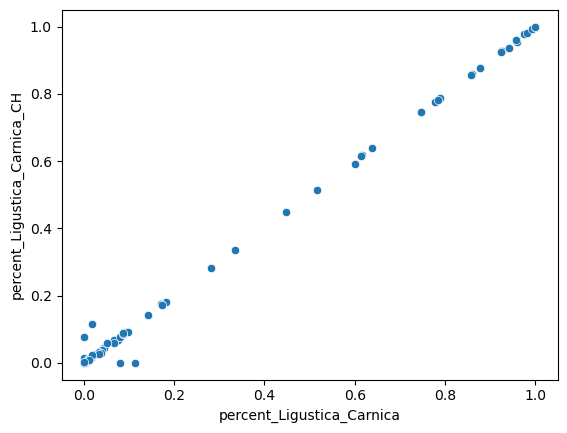

In [68]:
sns.scatterplot(data=adm_df, x = 'percent_Ligustica_Carnica', y = 'percent_Ligustica_Carnica_CH')

<Axes: xlabel='percent_Mellifera', ylabel='percent_Mellifera_CH'>

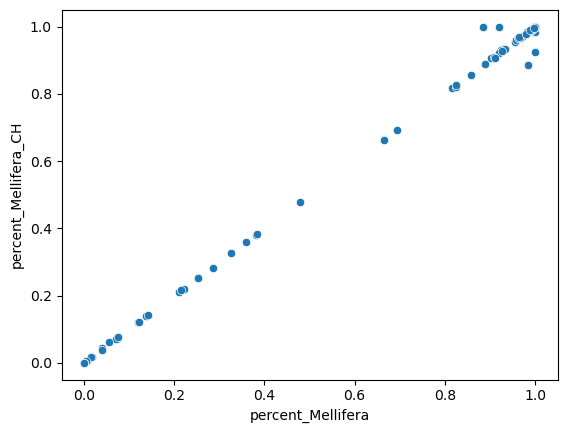

In [69]:
sns.scatterplot(data=adm_df, x = 'percent_Mellifera', y = 'percent_Mellifera_CH')

<Axes: xlabel='percent_Caucasica', ylabel='percent_Caucasica'>

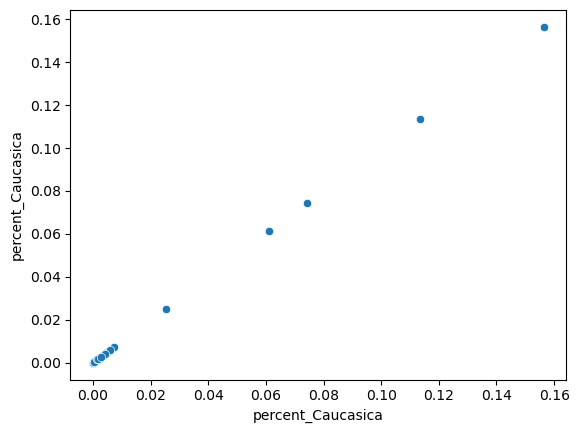

In [70]:
sns.scatterplot(data=adm_df, x = 'percent_Caucasica', y = 'percent_Caucasica')